In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd "/content/drive/My Drive/forest-cover-type-kernels-only"
!ls

/content/drive/My Drive/forest-cover-type-kernels-only
Forest-cover.ipynb     sub_CNN.csv	Submission4.csv  train.csv
sample_submission.csv  Submission3.csv	test.csv


In [3]:
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras import backend as K

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import io
%matplotlib inline

Using TensorFlow backend.


In [0]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB, MultinomialNB,  BernoulliNB
from sklearn.metrics import accuracy_score, log_loss,jaccard_similarity_score
import math
from sklearn.preprocessing import normalize

import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [0]:
!pip install heamy

In [0]:
import logging
from heamy.dataset import Dataset
from heamy.estimator import Classifier
from heamy.pipeline import ModelsPipeline

In [0]:
CACHE=False

NFOLDS = 5
SEED = 1337
METRIC = log_loss

ID = 'Id'
TARGET = 'Cover_Type'

np.set_printoptions(precision=5)
np.set_printoptions(suppress=True)

np.random.seed(SEED)
#logging.basicConfig(level=logging.DEBUG)
logging.basicConfig(level=logging.WARNING)

In [0]:
def soil_ftr(train_df):  
  print("starting soil_ftr")
  
  soil_type=[col for col in train_df.columns if 'Soil_Type' in col]
  correct_soil_type=[]

  for row in range(train_df.shape[0]):
    soil=-1
    i=0
    for col in soil_type:
      i=i+1
      if train_df.loc[row,col]==1:
        soil=i
        break

    correct_soil_type.append(soil)


  train_df['Soil_Type']=pd.Series(correct_soil_type)
  train_df.drop(soil_type,axis=1,inplace=True)
  return train_df

In [0]:
def wild_ftr(train_df):  
  print("starting wild_ftr")
  
  wild_type=[col for col in train_df.columns if 'Wilderness_Area' in col]
  
  correct_wild_type=[]

  for row in range(train_df.shape[0]):
    wild=-1
    i=0
    for col in wild_type:
      i=i+1
      if train_df.loc[row,col]==1:
        wild=i
        break

    correct_wild_type.append(wild)

 
  train_df['Wild_Type']=pd.Series(correct_wild_type)
  train_df.drop(wild_type,axis=1,inplace=True)
  
  return train_df 

In [0]:
def extra_ftr(train_df):
  print("starting extra_ftr")
  
  train_df['HF1'] = train_df['Horizontal_Distance_To_Hydrology']+train_df['Horizontal_Distance_To_Fire_Points']
  train_df['HF2'] = abs(train_df['Horizontal_Distance_To_Hydrology']-train_df['Horizontal_Distance_To_Fire_Points'])
  train_df['HR1'] = abs(train_df['Horizontal_Distance_To_Hydrology']+train_df['Horizontal_Distance_To_Roadways'])
  train_df['HR2'] = abs(train_df['Horizontal_Distance_To_Hydrology']-train_df['Horizontal_Distance_To_Roadways'])
  train_df['FR1'] = abs(train_df['Horizontal_Distance_To_Fire_Points']+train_df['Horizontal_Distance_To_Roadways'])
  train_df['FR2'] = abs(train_df['Horizontal_Distance_To_Fire_Points']-train_df['Horizontal_Distance_To_Roadways'])
  train_df['ele_vert'] = train_df.Elevation-train_df.Vertical_Distance_To_Hydrology

  train_df['slope_hyd'] = (train_df['Horizontal_Distance_To_Hydrology']**2+train_df['Vertical_Distance_To_Hydrology']**2)**0.5
  train_df.slope_hyd=train_df.slope_hyd.map(lambda x: 0 if np.isinf(x) else x) # remove infinite value if any

  #Mean distance to Amenities 
  train_df['Mean_Amenities']=(train_df.Horizontal_Distance_To_Fire_Points + train_df.Horizontal_Distance_To_Hydrology + train_df.Horizontal_Distance_To_Roadways) / 3 
  #Mean Distance to Fire and Water 
  train_df['Mean_Fire_Hyd']=(train_df.Horizontal_Distance_To_Fire_Points + train_df.Horizontal_Distance_To_Hydrology) / 2 
  
  return train_df

In [0]:
from sklearn import preprocessing

def normaalize(train_df):
  scaler = preprocessing.MinMaxScaler(feature_range=(0, 1), copy=False).fit(train_df)
  scaler.transform(train_df)
  return train_df

Run the code blocks  below for CNN model

In [6]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
print("train and test df loaded ")

train_lbl = train_df['Cover_Type']
#train_df = soil_ftr(train_df)
#train_df = wild_ftr(train_df)
train_df = extra_ftr(train_df)

#test_df = soil_ftr(test_df)
#test_df = wild_ftr(test_df)
test_df = extra_ftr(test_df) 

train_df.drop(['Id','Cover_Type','Elevation'],axis=1,inplace=True)
test_df.drop(['Id','Elevation'],axis=1,inplace=True)

train_df=np.array(train_df)
test_df=np.array(test_df)

train_df=normaalize(train_df)
test_df=normaalize(test_df)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_df, train_lbl, test_size=0.3, random_state=42)

train and test df loaded 
starting extra_ftr
starting extra_ftr


In [7]:
y_train=y_train.reshape(len(y_train),1)
y_test=y_test.reshape(len(y_test),1)

print("Shape of y_train : ",y_train.shape)
print("Shape of y_test : ",y_test.shape)

print("Shape of X_train : ",X_train.shape)
print("Shape of X_test : ",X_test.shape)

print(test_df.shape)

Shape of y_train :  (10584, 1)
Shape of y_test :  (4536, 1)
Shape of X_train :  (10584, 63)
Shape of X_test :  (4536, 63)
(565892, 63)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


In [8]:
from keras.layers import Activation

batch_size = 256
epochs = 30
img_rows, img_cols, channels = 1,63 , 1

if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], channels, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], channels, img_rows, img_cols)
    input_shape = (channels, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, channels)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, channels)
    input_shape = (img_rows, img_cols, channels)
    
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')

X_train shape: (10584, 1, 63, 1)
10584 train samples


In [0]:
model = Sequential()
model.add(Conv2D(4, kernel_size=(1, 3), padding='same', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(8, kernel_size=(1, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(16, kernel_size=(1, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, kernel_size=(1, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size=(1, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))


In [10]:
y_trn=np.zeros((len(y_train),7), dtype=int)
y_tst=np.zeros((len(y_test),7), dtype=int)

for row in range(len(y_train)):
  y_trn[row][y_train[row][0]-1]=1

for row in range(len(y_test)):
  y_tst[row][y_test[row][0]-1]=1
  
  
print(y_trn[7])
print(y_tst[1])

print(y_train[7])
print(y_test[1])

print(y_trn.shape)

[0 0 0 1 0 0 0]
[0 0 1 0 0 0 0]
[4]
[3]
(10584, 7)


In [11]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

history = model.fit(X_train, y_trn, batch_size=batch_size, epochs=25, verbose=1, validation_data=(X_test, y_tst))

score = model.evaluate(X_test, y_tst, verbose=2)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 10584 samples, validate on 4536 samples
Epoch 1/25
10584/10584 [==============================] - 4s 374us/step - loss: 1.0314 - acc: 0.6004 - val_loss: 0.8015 - val_acc: 0.6667
Epoch 2/25
10584/10584 [==============================] - 1s 80us/step - loss: 0.7566 - acc: 0.6888 - val_loss: 0.6491 - val_acc: 0.7418
Epoch 3/25
10584/10584 [==============================] - 1s 77us/step - loss: 0.6469 - acc: 0.7371 - val_loss: 0.6217 - val_acc: 0.7571
Epoch 4/25
10584/10584 [==============================] - 1s 78us/step - loss: 0.5726 - acc: 0.7671 - val_loss: 0.6126 - val_acc: 0.7551
Epoch 5/25
10584/10584 [==============================] - 1s 80us/step - loss: 0.5197 - acc: 0.7890 - val_loss: 0.5237 - val_acc: 0.7897
Epoch 6/25
10584/10584 [==============================] - 1s 81us/step - loss: 0.4811 - acc: 0.8059 - val_loss: 0.5205 - val_acc: 0.7912
Epoch 7/25
10584/10584 [==============================] - 1s 81us/step - loss: 0.4492 - acc: 0.8238 - val_loss: 0.4800 - val_acc

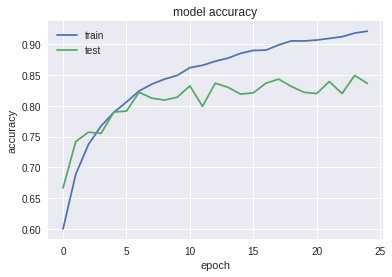

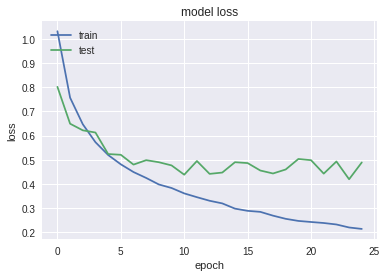

In [12]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
if K.image_data_format() == 'channels_first':
    test_df = test_df.reshape(test_df.shape[0], channels, img_rows, img_cols)
    input_shape = (channels, img_rows, img_cols)
else:
    test_df = test_df.reshape(test_df.shape[0], img_rows, img_cols, channels)
    input_shape = (img_rows, img_cols, channels)
    
print('X_train shape:', test_df.shape)
print(test_df.shape[0], 'train samples')

X_train shape: (565892, 1, 63, 1)
565892 train samples


In [0]:
predictions = model.predict(test_df)

In [15]:
print(predictions.shape)
print(predictions[:5])

pred=np.argmax(predictions, axis = 1)+1
print(pred[:5])
print(pred.shape)

(565892, 7)
[[1.09775290e-01 8.90104115e-01 3.37411620e-07 2.42123008e-07
  4.10387765e-05 5.74812908e-08 7.89901824e-05]
 [5.50783932e-01 4.48954463e-01 1.09649996e-07 3.30339205e-08
  1.11584804e-05 5.92938392e-08 2.50257493e-04]
 [3.42730612e-01 6.57149732e-01 9.51184006e-07 1.76390685e-07
  8.14449450e-05 6.36721722e-07 3.64511543e-05]
 [3.11126858e-01 6.88547194e-01 1.67531448e-06 7.26138978e-07
  2.49940116e-04 7.28521627e-07 7.28584928e-05]
 [2.76034176e-01 7.23216474e-01 2.84349949e-06 2.22122890e-06
  6.02483167e-04 7.94793266e-07 1.41009325e-04]]
[2 1 2 2 2]
(565892,)


In [16]:
sub=pd.read_csv("test.csv",usecols=['Id'])

print(sub.shape)
sub['Cover_Type']=pd.Series(pred)
sub.to_csv('CNN_normalized.csv',index=False)

(565892, 1)


Run the codes below to use Tree Ensemble Model 

In [0]:
def load_and_process_dataset():
    train = pd.read_csv("train.csv")
    test = pd.read_csv("test.csv")

    y_train = train[TARGET].ravel() -1 # XGB needs labels starting with 0!
    
    classes = train.Cover_Type.unique()
    num_classes = len(classes)
    print("There are %i classes: %s " % (num_classes, classes))        

    train.drop([ID, TARGET], axis=1, inplace=True)
    test.drop([ID], axis=1, inplace=True)
    
    train = soil_ftr(train)
    train = wild_ftr(train)
    train = extra_ftr(train)
    
    test = soil_ftr(test)
    test = wild_ftr(test)
    test = extra_ftr(test)    
    
    
    train = train.drop('Elevation', axis=1)
    test = test.drop('Elevation', axis=1)    
    
    x_train = train.values
    x_test = test.values

    return {'X_train': x_train, 'X_test': x_test, 'y_train': y_train}

In [0]:
dataset = Dataset(preprocessor=load_and_process_dataset, use_cache=True)

In [0]:
rf_params = {
    'n_estimators': 200,
    'criterion': 'entropy',
    'random_state': 0
}

rf1_params = {
    'n_estimators': 200,
    'criterion': 'gini',
    'random_state': 0
}

et1_params = {
    'n_estimators': 200,
    'criterion': 'gini',
    'random_state': 0
}

et_params = {
    'n_estimators': 200,
    'criterion': 'entropy',
    'random_state': 0
}

lgb_params = {
    'n_estimators': 200, 
    'learning_rate':0.1
}

logr_params = {
        'solver' : 'liblinear',
        'multi_class' : 'ovr',
        'C': 1,
        'random_state': 0}

In [0]:
rf = Classifier(dataset=dataset, estimator = RandomForestClassifier, use_cache=CACHE, parameters=rf_params,name='rf')
print("rf")

et = Classifier(dataset=dataset, estimator = ExtraTreesClassifier, use_cache=CACHE, parameters=et_params,name='et')
print("et")

rf1 = Classifier(dataset=dataset, estimator=RandomForestClassifier, use_cache=CACHE, parameters=rf1_params,name='rf1')
print("rf1")

et1 = Classifier(dataset=dataset, use_cache=CACHE, estimator=ExtraTreesClassifier, parameters=et1_params,name='et1')
print("et1")

lgbc = Classifier(dataset=dataset, estimator=LGBMClassifier, use_cache=CACHE, parameters=lgb_params,name='lgbc')
print("lgbc")

gnb = Classifier(dataset=dataset,estimator=GaussianNB, use_cache=CACHE, name='gnb')
print("gnb")

logr = Classifier(dataset=dataset, estimator=LogisticRegression, use_cache=CACHE, parameters=logr_params,name='logr')
print("logr")

rf
et
rf1
et1
lgbc
gnb
logr


In [0]:
def xgb_first(X_train, y_train, X_test, y_test=None):
    xg_params = {
        'seed': 0,
        'colsample_bytree': 0.7,
        'silent': 1,
        'subsample': 0.7,
        'learning_rate': 0.1,
        'objective': 'multi:softprob',   
        'num_class': 7,
        'max_depth': 4,
        'min_child_weight': 1,
        'eval_metric': 'mlogloss',
        'nrounds': 200
    }    
    X_train = xgb.DMatrix(X_train, label=y_train)
    model = xgb.train(xg_params, X_train, xg_params['nrounds'])
    return model.predict(xgb.DMatrix(X_test))

In [0]:
xgb_first = Classifier(estimator=xgb_first, dataset=dataset, use_cache=CACHE, name='xgb_first') 

In [0]:
pipeline = ModelsPipeline(rf, et, et1, lgbc, logr, gnb, xgb_first) 

stack_ds = pipeline.stack(k=NFOLDS,seed=SEED)

In [0]:
dtrain = xgb.DMatrix(stack_ds.X_train, label=stack_ds.y_train)
dtest = xgb.DMatrix(stack_ds.X_test)

xgb_params = {
    'seed': 0,
    'colsample_bytree': 0.8,
    'silent': 1,
    'subsample': 0.6,
    'learning_rate': 0.05,
    'objective': 'multi:softprob',
    'num_class': 7,        
    'max_depth': 6,
    'num_parallel_tree': 1,
    'min_child_weight': 1,
    'eval_metric': 'mlogloss',
}

res = xgb.cv(xgb_params, dtrain, num_boost_round=1000, 
             nfold=NFOLDS, seed=SEED, stratified=True,
             early_stopping_rounds=20, verbose_eval=5, show_stdv=True)

best_nrounds = res.shape[0] - 1
cv_mean = res.iloc[-1, 2]
cv_std = res.iloc[-1, 3]

print('Ensemble-CV: {0}+{1}, best nrounds = {2}'.format(cv_mean, cv_std, best_nrounds))

[0]	train-mlogloss:1.80214+0.000282434	test-mlogloss:1.80598+0.000577632
[5]	train-mlogloss:1.31788+0.000872974	test-mlogloss:1.33759+0.00161825
[10]	train-mlogloss:1.02329+0.00124902	test-mlogloss:1.05533+0.00246449
[15]	train-mlogloss:0.819546+0.0010386	test-mlogloss:0.862278+0.00329664
[20]	train-mlogloss:0.671009+0.00117647	test-mlogloss:0.723259+0.00395591
[25]	train-mlogloss:0.559379+0.00127167	test-mlogloss:0.620293+0.0043042
[30]	train-mlogloss:0.473625+0.0014086	test-mlogloss:0.542543+0.00469899
[35]	train-mlogloss:0.407017+0.00135371	test-mlogloss:0.483044+0.00514531
[40]	train-mlogloss:0.35463+0.00151074	test-mlogloss:0.437178+0.00543984
[45]	train-mlogloss:0.313112+0.00139845	test-mlogloss:0.401771+0.00544842
[50]	train-mlogloss:0.280078+0.00115316	test-mlogloss:0.374358+0.00543412
[55]	train-mlogloss:0.253361+0.000882569	test-mlogloss:0.352708+0.00581225
[60]	train-mlogloss:0.231826+0.000859505	test-mlogloss:0.336009+0.00601835
[65]	train-mlogloss:0.214234+0.000933401	test

In [0]:
model = xgb.train(xgb_params, dtrain, best_nrounds)

xpreds_proba = model.predict(dtest)

# Note: labels starting with 0 in xgboost, therefore adding +1!
predictions = np.round(np.argmax(xpreds_proba, axis=1)).astype(int) + 1

In [0]:
sub=pd.DataFrame(pd.read_csv("test.csv")["Id"],columns=["Id"])
sub[TARGET] = predictions
sub.to_csv("Submission4.csv",index=False)